In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
pd.set_option('display.max_row', 1000)
import os

# Any results you write to the current directory are saved as output.

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [132]:
game_data = pd.read_csv("game_data.csv")
player_data = pd.read_csv("player_data.csv")
training_data = pd.read_csv("training_set.csv", parse_dates = ['Game_Date'])
test_data = pd.read_csv("test_set.csv", parse_dates = ['Game_Date'])

In [133]:
#note to self, add date data, w/l, all-star to training data, city populations?
#Also add social media followings? For both players and teams

[game_data.shape, player_data.shape, training_data.shape, test_data.shape]

[(4920, 16), (77392, 23), (280625, 7), (460, 6)]

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


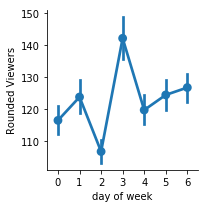

In [134]:
training_data['day of week'] = training_data.Game_Date.dt.dayofweek
g = sns.FacetGrid(training_data)
g.map(sns.pointplot, 'day of week',  'Rounded Viewers')



In [135]:
# just double checking that the graph was correct
training_data[['day of week', 'Rounded Viewers']].groupby(['day of week']).mean()

,Rounded Viewers
day of week,
0,116.475991
1,123.798095
2,106.700065
3,142.218299
4,119.721290
5,124.461662
6,126.770177


In [136]:
#checking the outliers possibly, it was on a tuesday?

training_data.loc[training_data['Rounded Viewers'].idxmax()]

Season                         2017-18
Game_ID                       21700001
Game_Date          2017-10-17 00:00:00
Away_Team                          BOS
Home_Team                          CLE
Country                           C176
Rounded Viewers                  18600
day of week                          1
Name: 145547, dtype: object

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


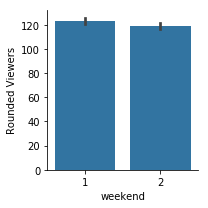

In [137]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 2)
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'weekend',  'Rounded Viewers')


In [138]:
training_data.Country.unique()

array(['C113', 'C193', 'C126', 'C163', 'C73', 'C128', 'C208', 'C67',
       'C177', 'C171', 'C176', 'C124', 'C189', 'C224', 'C51', 'C42',
       'C212', 'C201', 'C199', 'C166', 'C46', 'C89', 'C139', 'C14', 'C172',
       'C183', 'C99', 'C91', 'C59', 'C125', 'C169', 'C195', 'C38', 'C116',
       'C62', 'C101', 'C55', 'C190', 'C145', 'C50', 'C35', 'C71', 'C182',
       'C44', 'C122', 'C31', 'C222', 'C94', 'C213', 'C184', 'C109', 'C223',
       'C7', 'C65', 'C78', 'C174', 'C13', 'C15', 'C3', 'C123', 'C108',
       'C12', 'C37', 'C179', 'C135', 'C21', 'C100', 'C178', 'C136', 'C66',
       'C155', 'C56', 'C85', 'C134', 'C211', 'C90', 'C130', 'C219', 'C41',
       'C154', 'C2', 'C143', 'C64', 'C76', 'C40', 'C70', 'C75', 'C105',
       'C92', 'C149', 'C218', 'C156', 'C23', 'C141', 'C103', 'C165',
       'C180', 'C80', 'C104', 'C198', 'C53', 'C115', 'C26', 'C60', 'C140',
       'C191', 'C45', 'C161', 'C146', 'C6', 'C203', 'C54', 'C22', 'C57',
       'C186', 'C215', 'C144', 'C95', 'C9', 'C133',

In [139]:
training_data.set_index("Game_ID", inplace = True)

In [144]:
total_views = training_data.groupby('Game_ID')['Rounded Viewers'].sum()

In [145]:
training_data['Total_Views'] = total_views

# Getting rid of country/view columns


In [146]:
training_data.drop(['Rounded Viewers', 'Country'], inplace = True, axis = 1)

In [147]:
training_data.drop_duplicates(inplace = True)

In [148]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 0)
player_data['AllStar'] = np.where(player_data.ASG_Team != "None", 1, 0)

In [149]:
player_data.set_index('Game_ID', inplace = True)
player_data

,Season,Game_Date,Team,Person_ID,Name,ASG_Team,Active_Status,Minutes,Points,Defensive_Rebounds,...,Blocks,Turnovers,Field_Goals,Field_Goals_Attempted,Three_Pointers,Three_Pointers_Attempted,Free_Throws,Free_Throws_Attempted,Personal_Fouls,AllStar
Game_ID,,,,,,,,,,,,,,,,,,,,,
21600001,2016-17,10/25/2016,CLE,101112,Channing Frye,None,Active,14.0,6.0,2.0,...,1.0,1.0,2.0,6.0,2.0,5.0,0.0,0.0,4.0,0
21600001,2016-17,10/25/2016,CLE,201567,Kevin Love,East ASG,Active,25.0,23.0,10.0,...,0.0,2.0,6.0,15.0,2.0,6.0,9.0,12.0,3.0,1
21600001,2016-17,10/25/2016,CLE,202681,Kyrie Irving,East ASG,Active,30.0,29.0,1.0,...,0.0,0.0,12.0,22.0,4.0,7.0,1.0,1.0,1.0,1
21600001,2016-17,10/25/2016,CLE,202684,Tristan Thompson,None,Active,22.0,0.0,4.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0
21600001,2016-17,10/25/2016,CLE,202697,Iman Shumpert,None,Active,14.0,2.0,1.0,...,1.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0
21600001,2016-17,10/25/2016,CLE,202732,DeAndre Liggins,None,Active,12.0,4.0,3.0,...,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,0
21600001,2016-17,10/25/2016,CLE,203895,Jordan McRae,None,Active,6.0,2.0,0.0,...,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0
21600001,2016-17,10/25/2016,CLE,1627770,Kay Felder,None,Inactive,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
21600001,2016-17,10/25/2016,CLE,2747,JR Smith,None,Active,25.0,8.0,3.0,...,0.0,0.0,3.0,13.0,2.0,8.0,0.0,0.0,1.0,0


In [151]:
allstar = player_data.groupby('Game_ID')['AllStar'].sum()
training_data['AllStar'] = allstar

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


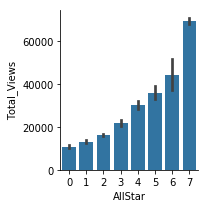

In [159]:
g = sns.FacetGrid(training_data)

g.map(sns.barplot, 'AllStar',  'Total_Views')

# There is a relationship between number of all stars and viewer count as seen here

Now we are going to try model on top of this. First is random forest. Our test model will be just a split of 0.25

In [203]:
X = training_data.copy()

y = X['Total_Views']
X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
print(X)

          day of week  weekend  AllStar
Game_ID                                
21600001            1        0        4
21600003            1        0        5
21600002            1        0        1
21600006            2        0        1
21600008            2        0        2
21600005            2        0        1
21600007            2        0        2
21600013            2        0        1
21600004            2        0        0
21600009            2        0        1
21600011            2        0        1
21600012            2        0        1
21600015            3        0        2
21600017            3        0        1
21600016            3        0        2
21600014            3        0        2
21600022            4        1        1
21600018            4        1        5
21600025            4        1        5
21600019            4        1        1
21600024            4        1        1
21600020            4        1        0
21600021            4        1        1


In [196]:
from sklearn.model_selection import train_test_split

In [197]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)

In [199]:
randomforest = RandomForestClassifier()
randomforest.fit(train_X, train_y)

randomforest_predictions = randomforest.predict(val_X)

In [201]:
mape = np.mean(np.abs((val_y - randomforest_predictions) / val_y)) * 100

In [202]:
print(mape)

61.312557443


In [208]:
from xgboost import XGBClassifier

In [209]:
xgboost = XGBClassifier()
xgboost.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [210]:
xgboostpredict = xgboost.predict(val_X)

mape = np.mean(np.abs((val_y - xgboostpredict) / val_y)) * 100

In [211]:
print(mape)

48.7460028956
